In [3]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, Normalizer
from sklearn.model_selection import StratifiedShuffleSplit
import pickle
from numpy.random import choice
import os.path

import tensorflow as tf
import numpy as np

In [4]:
tf.enable_eager_execution()

#### Import model, training function 

In [5]:
from annsa.model_classes import (dae_model_features,
                                 DAE,
                                 train_earlystop)

#### Load Dataset

In [6]:
dataset = np.load('../dataset_generation/hyperparametersearch_dataset_200keV_full_log10time_1000.npy')

# all_spectra = np.random.poisson(np.add(np.array(dataset.item()['sources'], dtype=float),
#                                        np.array(dataset.item()['backgrounds'], dtype=float)))

all_spectra = np.add(np.array(dataset.item()['sources'], dtype=float),
                                       np.array(dataset.item()['backgrounds'], dtype=float))

all_keys = np.array(dataset.item()['sources'], dtype=float) # background subtracted output

keys_raw = dataset.item()['keys'] # keys necessary for stratified


## Train network

In [53]:
earlystop_errors_test = []
model_id='dae-full-final'

In [8]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=5)


In [54]:

##########################
### Define Autoencoder ###
##########################
dense_nodes_encoder = [32]
dense_nodes_decoder = []


dae_features = dae_model_features(
    learning_rate=10**-4,
    l1_regularization_scale=0.0,
    dropout_probability=0.0,
    batch_size=2**4,
    output_size=1024,
    dense_nodes_encoder=dense_nodes_encoder,
    dense_nodes_decoder=dense_nodes_decoder,
    scaler=make_pipeline(FunctionTransformer(np.sqrt, validate=True), Normalizer(norm='max')),
    activation_function=tf.nn.relu,
    output_function=None)

In [55]:
with open('../hyperparameter_search/hyperparameter-search-results/' + model_id, 'wb+') as f:
    pickle.dump(dae_features,f)

In [10]:

dae_optimizer = tf.train.AdamOptimizer(dae_features.learning_rate)

k_folds_errors = []
dae_models = []

k = 0

for train_index, test_index in sss.split(all_spectra, keys_raw):

    # reset model on each iteration
    dae_model = DAE(dae_features)
    dae_model.scaler.fit(all_spectra[train_index])

    ##########################
    #### Train Autoencoder ###
    ##########################

    costfunction_errors_dae_tmp, earlystop_errors_dae_tmp = train_earlystop(
        training_data=all_spectra[train_index],
        training_keys=all_keys[train_index],
        testing_data=all_spectra[test_index],
        testing_keys=all_keys[test_index],
        model=dae_model,
        optimizer=dae_optimizer,
        num_epochs=500,
        obj_cost=dae_model.mse,
        earlystop_cost_fn=dae_model.mse,
        earlystop_patience=10,
        verbose=True,
        fit_batch_verbose=1,
        data_augmentation=dae_model.poisson_data_augmentation)

    k_folds_errors.append(earlystop_errors_dae_tmp)
    dae_models.append(dae_model)
    dae_model.save_weights('./final-models/'+model_id+'_pretrained'+'_checkpoint_'+str(k))
    k += 1

INFO:tensorflow:Scale of 0 disables regularizer.
Epoch 1: CostFunc loss: 0.00 0.01, EarlyStop loss: 0.00 0.01
Epoch 2: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 3: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 4: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 5: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 6: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 7: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 8: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 9: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 10: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 11: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 12: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 13: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 14: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 15: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 16: CostFunc loss: 0.00 

Epoch 32: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 33: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 34: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 35: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 36: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 37: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 38: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 39: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 40: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 41: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 42: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 43: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 44: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 45: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 46: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 47: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 48

Epoch 63: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 64: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 65: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 66: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 67: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 68: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 69: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 70: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 71: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 72: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 73: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 74: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 75: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 76: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 77: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 78: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 79

Epoch 47: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 48: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 49: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 50: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 51: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 52: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 53: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 54: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 55: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 56: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 57: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 58: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 59: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 60: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 61: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 62: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 63

Epoch 59: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 60: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 61: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 62: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 63: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 64: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 65: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 66: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 67: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 68: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 69: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 70: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 71: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 72: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 73: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 74: CostFunc loss: 0.00 0.00, EarlyStop loss: 0.00 0.00
Epoch 75

### Load model

In [51]:
dae_models = {}

for index in range(5):
    dae_models[index] = DAE(dae_features)
    dae_models[index].load_weights('./final-models/'+model_id+'_pretrained_checkpoint_'+str(index))

0
INFO:tensorflow:Scale of 0 disables regularizer.
1
INFO:tensorflow:Scale of 0 disables regularizer.
2
INFO:tensorflow:Scale of 0 disables regularizer.
3
INFO:tensorflow:Scale of 0 disables regularizer.
4
INFO:tensorflow:Scale of 0 disables regularizer.


### Run example data

isotope: 60CO


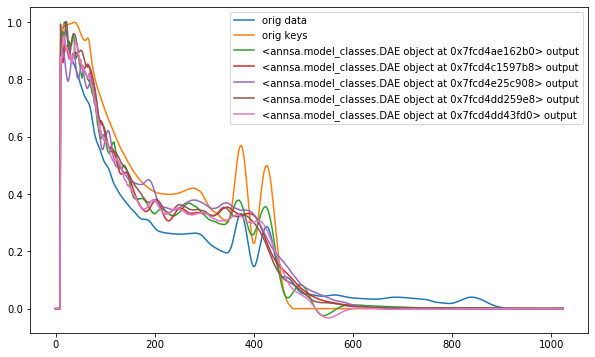

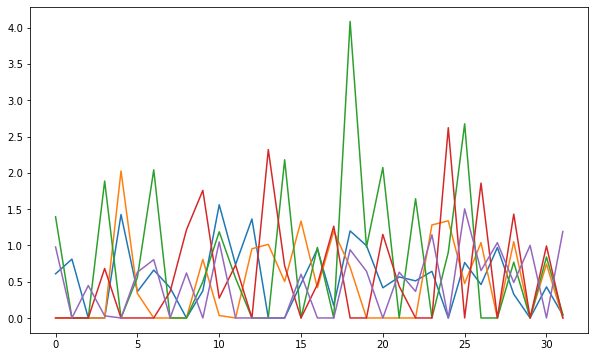

In [89]:
# index = 15012 # background
index = 17003

print('isotope: ' + keys_raw[index])
plt.figure(figsize=(10,6))
plt.plot(dae_models[0].scaler.transform(all_spectra[index:index+1])[0], label = 'orig data')
plt.plot(dae_models[0].scaler.transform(all_keys[index:index+1])[0], label = 'orig keys')

for model_index in dae_models:
    tmp_model = dae_models[model_index]    
    plt.plot(tmp_model.decoder(tmp_model.encoder(all_spectra[index:index+1])).numpy()[0], label = str(tmp_model)+' output')
    plt.legend()

plt.figure(figsize=(10,6))    
for model_index in dae_models:
    tmp_model = dae_models[model_index]    
    plt.plot(tmp_model.encoder(all_spectra[index:index+1]).numpy()[0])

In [ ]:
## 

In [ ]:
# index = 15012 # background
index = 100

print('isotope: ' + keys_raw[index])
plt.figure(figsize=(10,6))
plt.plot(dae_models[0].scaler.transform(all_spectra[index:index+1])[0], label = 'orig data')
plt.plot(dae_models[0].scaler.transform(all_keys[index:index+1])[0], label = 'orig keys')

for model_index in dae_models:
    tmp_model = dae_models[model_index]    
    plt.plot(tmp_model.decoder(tmp_model.encoder(all_spectra[index:index+1])).numpy()[0], label = str(tmp_model)+' output')
    plt.legend()

plt.figure(figsize=(10,6))    
for model_index in dae_models:
    tmp_model = dae_models[model_index]    
    plt.plot(tmp_model.encoder(all_spectra[index:index+1]).numpy()[0])

In [16]:
from sklearn.decomposition import PCA

In [12]:
dae_model_bs_sqrt = DAE(dae_features)
dae_model_bs_sqrt.load_weights('./final-models/BS-DAE_draft_shielded_dataset_100_fwhm6_sqrt')

dae_model_bs_log10p = DAE(dae_features)
dae_model_bs_log10p.load_weights('./final-models/BS-DAE_draft_shielded_dataset_100_fwhm6_log10p')

dae_model_vanilla_sqrt = DAE(dae_features)
dae_model_vanilla_sqrt.load_weights('./final-models/VANILLA-DAE_draft_shielded_dataset_100_fwhm6_sqrt')

dae_model_vanilla_log10p = DAE(dae_features)
dae_model_vanilla_log10p.load_weights('./final-models/VANILLA-DAE_draft_shielded_dataset_100_fwhm6_log10p')

# Visualize 2D PCA of BS-DAE outputs 

In [13]:
def visualize_2d_PCA(model, dataset, plot=False):
    pca = PCA(n_components = 2)
    pca.fit(model.encoder(dataset).numpy())
    for k in range(100):
        for i in range(10):
            pca_vals = pca.transform(model.encoder(dataset[300*i+k:300*i+k+1]).numpy())[0][0:2]
            if plot == True:
                plt.scatter(pca_vals[0], pca_vals[1], label = str(i))
    return pca_vals

Text(0.5,1,'vanilla-DAE-sqrt')

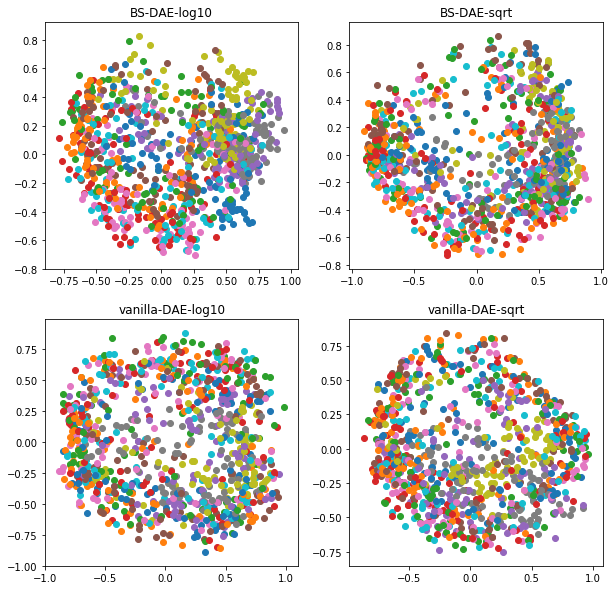

In [19]:
plt.figure(figsize=(10,10))

# BS-DAE-log10
plt.subplot(221)
visualize_2d_PCA(dae_model_bs_log10p, all_spectra, True)
plt.title('BS-DAE-log10')
plt.xlim([])

# BS-DAE-sqrt
plt.subplot(222)
visualize_2d_PCA(dae_model_bs_sqrt, all_spectra, True)
plt.title('BS-DAE-sqrt')

# vanilla-DAE-log10
plt.subplot(223)
visualize_2d_PCA(dae_model_vanilla_log10p, all_spectra, True)
plt.title('vanilla-DAE-log10')

# vanilla-DAE-sqrt
plt.subplot(224)
visualize_2d_PCA(dae_model_vanilla_sqrt, all_spectra, True)
plt.title('vanilla-DAE-sqrt')

#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                    wspace=0.35)

### Visualize 2D PCA of preprocessed spectra 

Text(0.5,1,'sqrt')

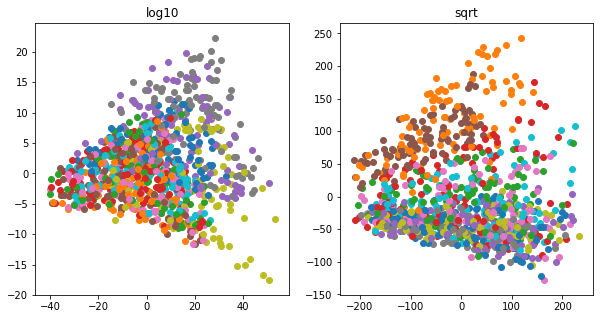

In [85]:

plt.figure(figsize=(10,5))

# log10
#plt.subplot(121)
plt.subplot(121)
pca = PCA(n_components=2)
pca.fit(np.log1p(all_spectra))
for k in range(100):
    for i in range(10):
        pca_vals = pca.transform(np.log1p(all_spectra[300*i+k:300*i+k+1]))[0][0:2]
        plt.scatter(pca_vals[0],pca_vals[1], label=str(i))
plt.title('log10')

# BS-DAE-sqrt
plt.subplot(122)
pca = PCA(n_components=2)
pca.fit(np.sqrt(all_spectra))
for k in range(100):
    for i in range(10):
        pca_vals = pca.transform(np.sqrt(all_spectra[300*i+k:300*i+k+1]))[0][0:2]
        plt.scatter(pca_vals[0],pca_vals[1], label=str(i))
plt.title('sqrt')

### Comparing output

In [79]:
all_models = [dae_model_bs_log10p,
              dae_model_bs_sqrt,
              dae_model_vanilla_log10p,
              dae_model_vanilla_sqrt]

In [97]:
tmp_model

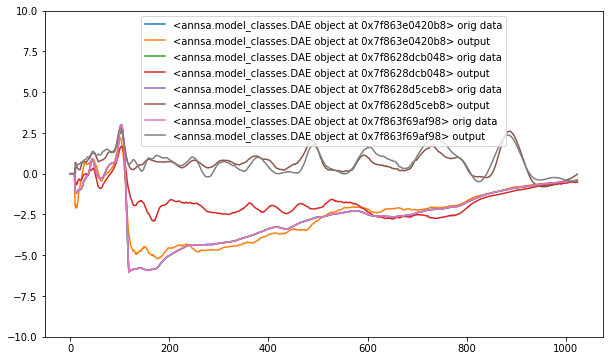

In [98]:
index = 850

plt.figure(figsize=(10,6))
for tmp_model in all_models:
    plt.plot(tmp_model.scaler.transform(all_source_spectra[index:index+1])[0], label = str(tmp_model)+' orig data')
    plt.plot(tmp_model.decoder(tmp_model.encoder(all_spectra[index:index+1])).numpy()[0], label = str(tmp_model)+' output')
plt.ylim([-10,10])
plt.legend()

# Use a dataset outside training

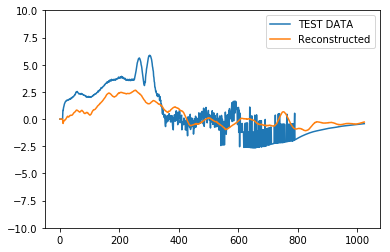

In [142]:
tmp_model = dae_model

index = 407

plt.plot(tmp_model.scaler.transform(all_spectra_TEST[index:index+1])[0], label='TEST DATA')
plt.plot(tmp_model.decoder(tmp_model.encoder(all_spectra_TEST[index:index+1])).numpy()[0], label='Reconstructed')
plt.ylim([-10,10])
plt.legend()

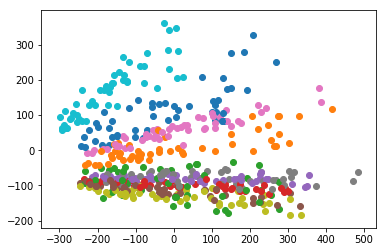

In [111]:
pca = PCA(n_components=2)
pca.fit(np.sqrt(all_spectra_TEST))

for k in range(50):
    for i in range(10):
        pca_vals = pca.transform(np.sqrt(all_spectra_TEST[125*i+k:125*i+k+1]))[0][0:2]
        plt.scatter(pca_vals[0], pca_vals[1], label=all_keys_TEST[i])
#plt.legend()
# all_spectra.shape

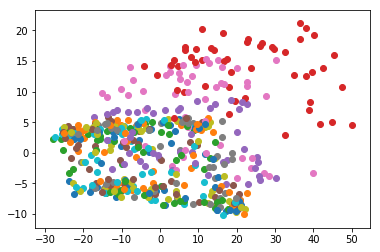

In [114]:
pca = PCA(n_components=2)
pca.fit(np.log1p(all_spectra_TEST))

for k in range(50):
    for i in range(10):
        pca_vals = pca.transform(np.log1p(all_spectra_TEST[125*i+k:125*i+k+1]))[0][0:2]
        plt.scatter(pca_vals[0], pca_vals[1], label=all_keys_TEST[i])
#plt.legend()
# all_spectra.shape

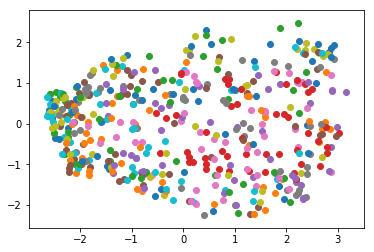

In [103]:
tmp_model = dae_model_vanilla_log10p

pca = PCA(n_components=2)
pca.fit(tmp_model.encoder(all_spectra_TEST).numpy())

for k in range(50):
    for i in range(10):
        pca_vals = pca.transform(tmp_model.encoder(all_spectra_TEST[125*i+k:125*i+k+1]).numpy())[0][0:2]
        plt.scatter(pca_vals[0], pca_vals[1], label=all_keys_TEST[i])
#plt.legend()
# all_spectra.shape